#### Import necessary libraries 

In [48]:
import numpy as np
import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, DataStructs, PandasTools
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from deepchem import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
import scipy
from sklearn.manifold import TSNE


#### Read in the preprocessed BBB dataset from Adenot paper

In [10]:
bbb_df = pd.read_csv('adenot_processed.csv')

In [11]:
bbb_df

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,THEOBROMINE,Cn1cnc2c1C(=O)NC(=O)N2C,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1665,AMITRIPTYLINE,CN(C)CCC=C1c2ccccc2CCc2ccccc12,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1666,CHLORPROMAZINE,CN(C)CCCN1c2ccccc2Sc2ccc(cc12)Cl,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1667,DISULFIRAM,CCN(CC)C(=S)SSC(=S)N(CC)CC,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Data preprocessing

In [15]:
X = bbb_df.iloc[:,3:].copy()
y = bbb_df.iloc[:,2].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### Random Forest

In [18]:
# Create a Random Forest Classifier
rf = RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=20, random_state=0)

# Train the model using the training sets
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

Accuracy: 0.9241516966067864


#### Hyperparameter Optimization

In [22]:
param_grid = ParameterGrid({'n_estimators': np.arange(50, 201, 50),
         'criterion': ['gini', 'entropy'],
         'max_depth': np.arange(5, 21, 5)
         })
accuracy = []
for params in param_grid: 
    rf = RandomForestClassifier(random_state=0, **params).fit(X_train, y_train)
    # Predict the response for test dataset
    y_pred = rf.predict(X_test)

    # Calculate how often the classifier is correct
    accuracy.append(metrics.accuracy_score(y_test, y_pred))

acc_df = pd.DataFrame(param_grid)
acc_df['accuracy'] = accuracy
acc_df.sort_values(by='accuracy', ascending=False, inplace=True)
acc_df.head(10)

,criterion,max_depth,n_estimators,accuracy
31,entropy,20,200,0.952096
14,gini,20,150,0.952096
29,entropy,20,100,0.952096
15,gini,20,200,0.952096
13,gini,20,100,0.952096
30,entropy,20,150,0.952096
12,gini,20,50,0.950100
26,entropy,15,150,0.950100
25,entropy,15,100,0.950100
24,entropy,15,50,0.948104


#### Optimized Random Forest

In [35]:
rf_best = RandomForestClassifier(random_state=0, n_estimators = 100, criterion='gini', max_depth=20).fit(X_train,y_train)

#### Feature Importances 

In [28]:
len(non_zero_index_list)

968

In [37]:
# You don't have to code anything here.

# get importance
dt_importance = rf_best.feature_importances_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

Text(0.5, 1.0, 'Top 10 Random Forest Feature Importances')

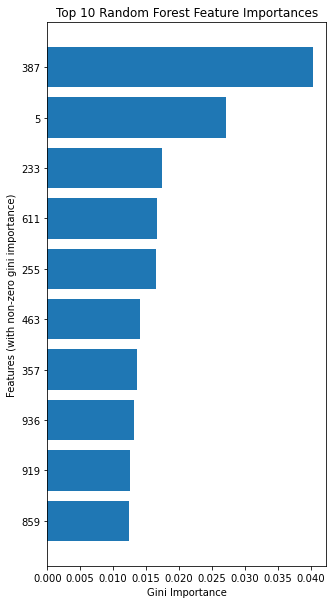

In [43]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][958:], feature_importance['Importance'][958:])
plt.title('Top 10 Random Forest Feature Importances')

#### Visualize the proximity of features using the apply method of random forest.

In [46]:
temp_trees = rf_best.apply(X_train)
temp_trees

prox = np.array([[1-.0-scipy.spatial.distance.hamming(i,ii) for i in temp_trees] for ii in temp_trees])
1-prox

array([[0.  , 0.96, 0.76, ..., 0.68, 0.59, 0.61],
       [0.96, 0.  , 0.97, ..., 0.96, 0.97, 0.95],
       [0.76, 0.97, 0.  , ..., 0.63, 0.63, 0.72],
       ...,
       [0.68, 0.96, 0.63, ..., 0.  , 0.55, 0.58],
       [0.59, 0.97, 0.63, ..., 0.55, 0.  , 0.47],
       [0.61, 0.95, 0.72, ..., 0.58, 0.47, 0.  ]])

In [49]:
X_embedded = TSNE(n_components=2, random_state=0, perplexity = 30).fit_transform(1-prox)

/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


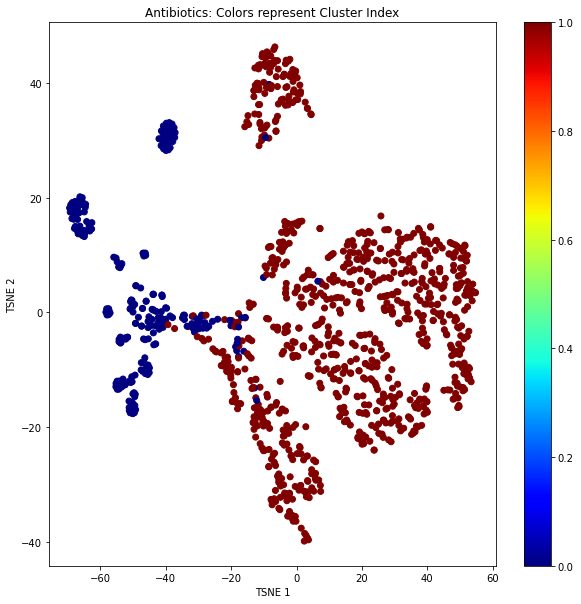

In [50]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=y_train, cmap='jet')

plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.title('Antibiotics: Colors represent Cluster Index')
plt.colorbar()